Fig. 5: FateID fate bias
---

In this notebook, we plot the FateID's fate bias. In order to reproduce the smoothed gene trends, please refer to
[MK_2020-17-10_plot_trends.ipynb](MK_2020-17-10_plot_trends.ipynb).

# Preliminaries

## Dependency notebooks

1. [analysis_notebooks/MK_2020-17-10_extract_fate_bias.ipynb](analysis_notebooks/MK_2020-17-10_extract_fate_bias.ipynb)

## Import packages

In [1]:
# import standard packages
import sys
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import single-cell packages
import scanpy as sc
import scvelo as scv
import cellrank as cr

# import CellRank utilities
from cellrank.tl import Lineage
from cellrank.tl._utils import _fuzzy_to_discrete, _series_from_one_hot_matrix
from cellrank.tl._colors import _colors_in_order

# set verbosity levels
sc.settings.verbosity = 2
cr.settings.verbosity = 2
scv.settings.verbosity = 3 

## Print package versions for reproducibility

In [4]:
cr.logging.print_versions()

cellrank==1.0.0-rc.12+gb3e00a8 scanpy==1.6.0 anndata==0.7.4 numpy==1.19.2 numba==0.51.2 scipy==1.5.2 pandas==1.1.3 scikit-learn==0.23.2 statsmodels==0.12.0 python-igraph==0.8.3 scvelo==0.2.3.dev26+g8351f46 pygam==0.8.0 matplotlib==3.3.2 seaborn==0.11.0


In [5]:
sys.path.insert(0, "../../..")  # this depends on the notebook depth and must be adapted per notebook

from paths import DATA_DIR, FIG_DIR

In [8]:
root_fig= FIG_DIR / "fig_5_benchmarking" / "fateid"

scv.settings.figdir = str(root_fig)
sc.settings.figdir = str(root_fig)
cr.settings.figdir = str(root_fig)

## Set global parameters

In [7]:
scv.settings.set_figure_params('scvelo', dpi_save=400, dpi=80, transparent=True, fontsize=16, color_map='viridis')
scv.settings.plot_prefix = ""

save_figure = True

## Load the data - TODO

In [ ]:
adata = scv.read(f"{file_paths['data_dir']}/benchmarking/fateid/09_20_fateid_bench.h5ad")

# rename fate probs for consistency
adata.obsm['to_terminal_states'] = adata.obsm['fateid_final_states'].copy()
if 'fateid_final_states' in adata.obsm.keys():
    del adata.obsm['fateid_final_states']

## Raw data preprocessing

In [5]:
# create the raw object
adata_raw = adata.copy()
sc.pp.filter_genes(adata_raw, min_cells=3)
sc.pp.normalize_total(adata_raw)
sc.pp.log1p(adata_raw)
adata.raw = adata_raw

adata

AnnData object with n_obs × n_vars = 2531 × 27998
    obs: 'day', 'proliferation', 'G2M_score', 'S_score', 'phase', 'clusters_coarse', 'clusters', 'clusters_fine', 'louvain_Alpha', 'louvain_Beta', 'fateid_clusters'
    var: 'highly_variable_genes'
    uns: 'clusters_colors', 'clusters_fine_colors', 'day_colors', 'fateid_clusters_colors', 'louvain_Alpha_colors', 'louvain_Beta_colors', 'pca'
    obsm: 'X_fateid_tsne', 'X_pca', 'X_umap', 'to_terminal_states'
    layers: 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

## Preprocess,and compute the moments

In [7]:
# filter, normalize, log transform
scv.pp.filter_and_normalize(adata, min_shared_counts=20, log=True, n_top_genes=2000)

# compute pca, knn graph and scvelo's moments
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=30)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 22024 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Exctracted 2000 highly variable genes.
Logarithmized X.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


## Compute DPT

Compute DPT using a cell from the Ngn3 low EP cluster as root cell. 

In [ ]:
sc.tl.diffmap(adata)

iroot = np.where(adata.obs['clusters'] == 'Ngn3 low EP')[0][0]
adata.uns['iroot'] = iroot
sc.tl.dpt(adata)

Compute DPT using a cell from the Ngn3 low EP cluster as root cell. 

## Visualize annotations

In [ ]:
scv.pl.scatter(adata, color=['clusters', 'fateid_clusters'])
scv.pl.scatter(adata, c=[iroot, 'dpt_pseudotime'], color_map="viridis")

# Plot the results

## Plot terminal states

These are not provided by FateID, at least not without prior knowledge about genes that mark mature populations. Therefore, we just return a grey umap:

saving figure to file /Users/marius/Projects/cellrank_notebooks_dev/figures//benchmarking/fateid/fateid_final_states.pdf


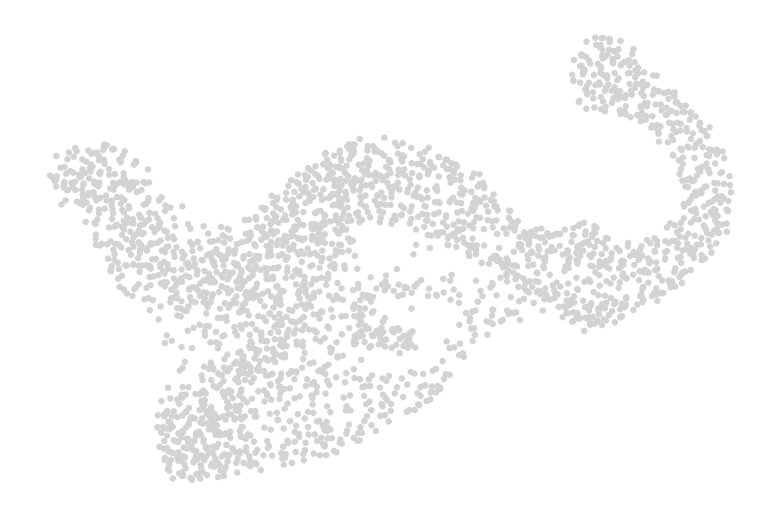

In [9]:
figure_kwargs = {'color': '#D3D3D3'}
if save_figure: figure_kwargs['save'] = 'final_states'
scv.pl.scatter(adata, **figure_kwargs)

## Plot fate map in multiple plots

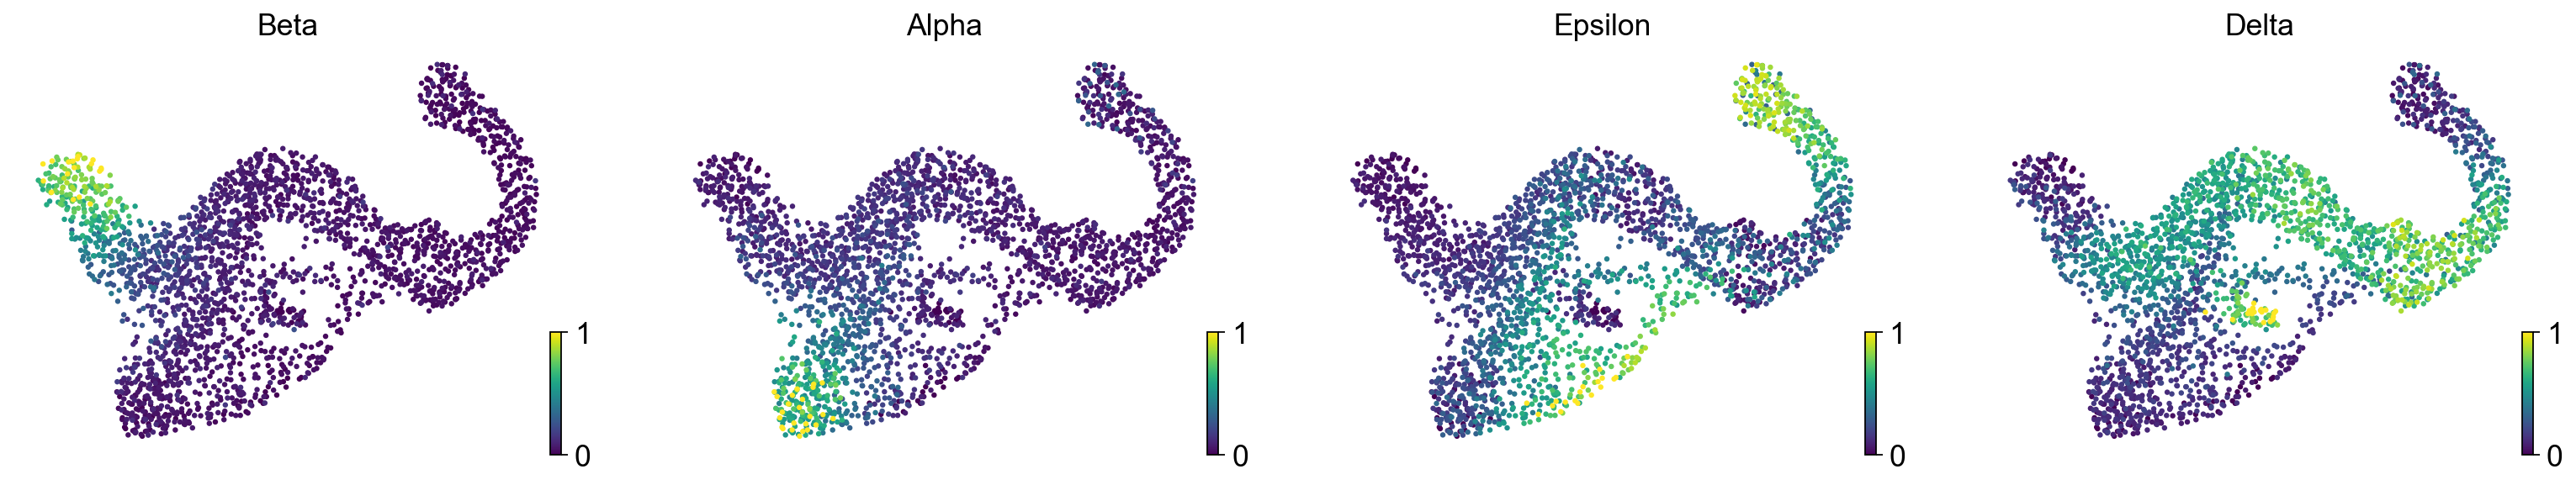

In [10]:
# look at individual fate vectors
fate_probs = adata.obsm['to_terminal_states']
scv.pl.scatter(adata, color=[a for a in fate_probs.T], color_map='viridis', title=['Beta', 'Alpha', 'Epsilon', 'Delta'])

## Plot fate map in 1 plot

saving figure to file /Users/marius/Projects/cellrank_notebooks_dev/figures//benchmarking/fateid/fateid_cell_fate_map.pdf


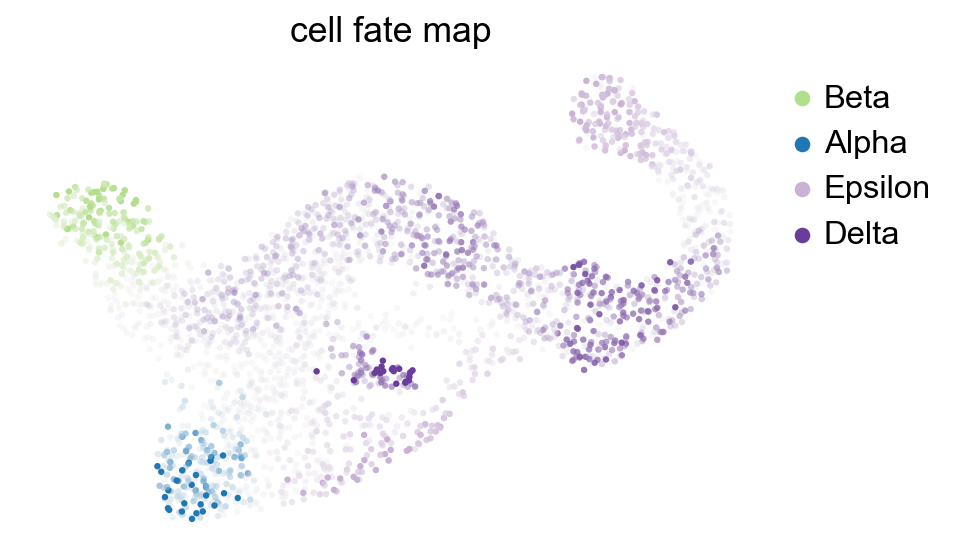

In [11]:
# put branch probs into lineage object, assign names and colors
X = fate_probs
names = ['Beta', 'Alpha', 'Epsilon', 'Delta']
colors = _colors_in_order(adata, clusters=names)
L = Lineage(X, names=names, colors=colors)

# from each state, select the most likely cells and save in adata
D, _ = _fuzzy_to_discrete(L, n_most_likely=30, check_row_sums=False)
adata.obs['terminal_states'] = _series_from_one_hot_matrix(D, index=adata.obs_names, names=L.names)
adata.uns['terminal_states_colors'] = L.colors
adata.uns['to_terminal_states_colors'] = L.colors
adata.obsm['to_terminal_states'] = L

figure_kwargs = {'title': 'cell fate map'}
if save_figure:
    figure_kwargs['save'] = 'cell_fate_map'
    
scv.pl.scatter(adata, color='terminal_states', color_gradients='to_terminal_states', **figure_kwargs)

## Plot heatmap over Fev+ subclustering

In [12]:
scv.settings.set_figure_params('scvelo', dpi_save=400, dpi=80, transparent=True, fontsize=18)

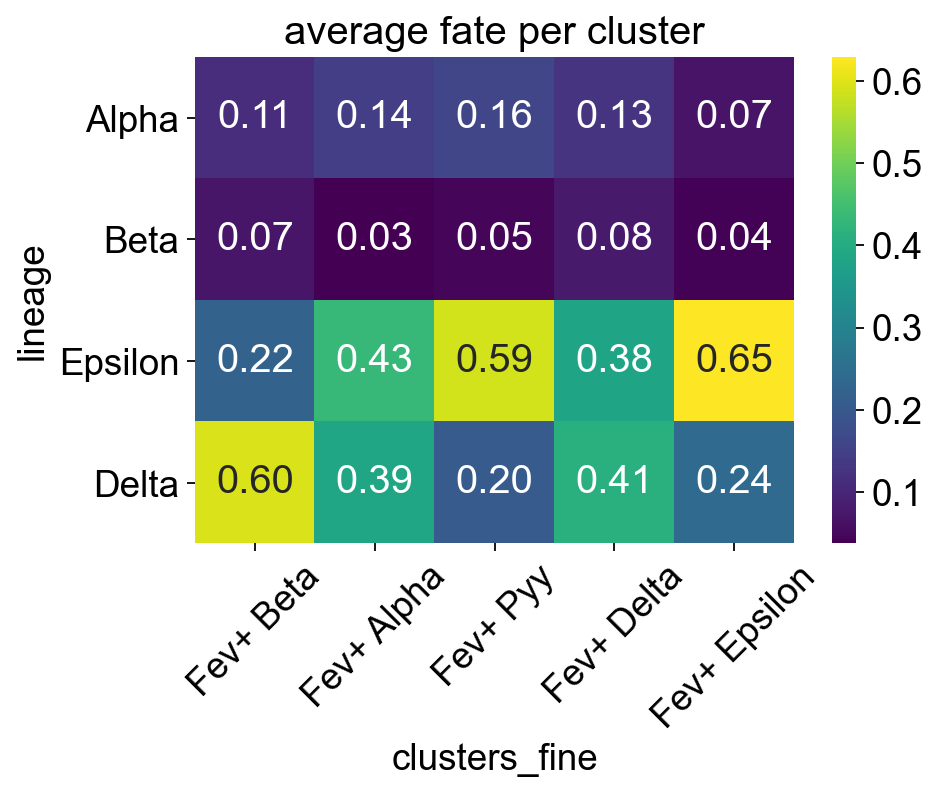

In [13]:
figure_kwargs = {'cluster_key': 'clusters_fine', 'mode': 'heatmap', 
                 'lineages': ['Alpha', 'Beta', 'Epsilon', 'Delta'],
                'clusters': ['Fev+ Beta', 'Fev+ Alpha', 'Fev+ Pyy', 'Fev+ Delta', 'Fev+ Epsilon']}
if save_figure:
    figure_kwargs['save'] = 'fateid_heatmap'
    
cr.pl.cluster_fates(adata, **figure_kwargs, )

## Plot heatmap only Ngn3 high EP

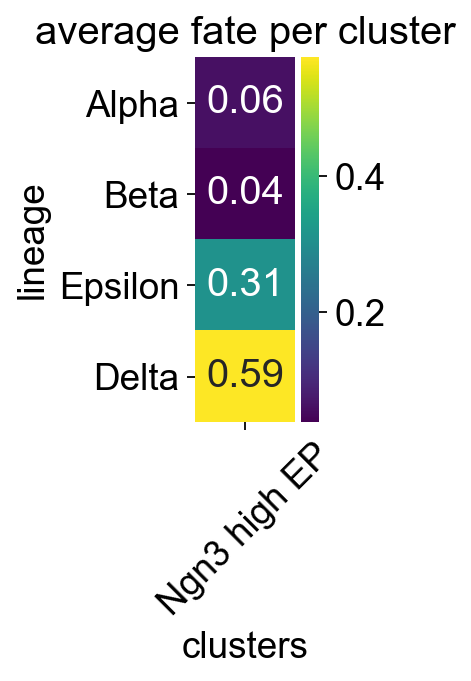

In [14]:
figure_kwargs = {'cluster_key': 'clusters', 'mode': 'heatmap', 
                 'lineages': ['Alpha', 'Beta', 'Epsilon', 'Delta'],
                'clusters': ['Ngn3 high EP'], 'figsize': (1, 3)}
if save_figure:
    figure_kwargs['save'] = 'palantir_heatmap_ngn3_high.pdf'
    
cr.pl.cluster_fates(adata, **figure_kwargs)